## This script runs all necessary scenarios and output collections for figure 3 and constructs figure 3

In [1]:
# Import all things necessary
from scenario_class import Scenario
from plots_class import Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import matplotlib.cm as cm
from scenariosweeper_class import ScenarioSweeper
import matplotlib.gridspec as gridspec

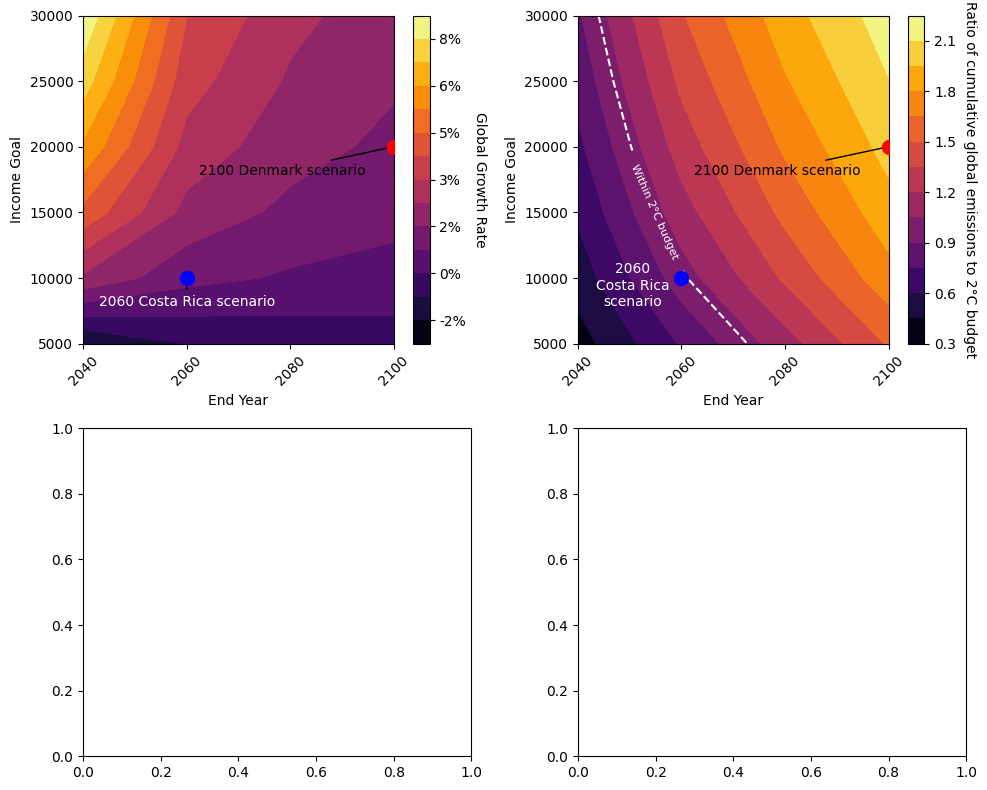

In [2]:
# Create a figure
fig = plt.figure(figsize=(10, 8))

# Define a GridSpec for a 2x2 grid
gs = gridspec.GridSpec(2, 2, figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
ax3 = fig.add_subplot(gs[1, 0])  # Bottom-left
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right


# calculate how much emissions are emitted in a given scenario run and how far above this is the carbon budget by summing the yearly emissions of all countries
# Example usage:
end_year_values = [2040, 2060, 2080, 2100]
income_goal_values = [5000, 10000, 15000, 20000, 25000, 30000]
carbon_budget_values = [1150]
gdp_assumption_values = ["constant_ratio"]
pop_growth_assumption_values = ["semi_log_model"]
tech_evolution_assumption_values = ["plausible"]
tech_hysteresis_assumption_values = ["off"]
sweeper1 = ScenarioSweeper(end_year_values,
                           income_goal_values,
                           carbon_budget_values,
                           gdp_assumption_values,
                           pop_growth_assumption_values,
                           tech_evolution_assumption_values,
                           tech_hysteresis_assumption_values)


output = sweeper1.run_scenarios() 
# output[0] is the emissions and output[1] is the gdp growth rate globally
input1 = output[0] # output now will be transformed to an input for the plots function
input2 = output[1] # output now will be transformed to an input for the plots function
# Create a new figure with four axes
sweeper1.plot_total_emissions_trade_off(input1, ["end_year", "income_goal"], ax2)
sweeper1.plot_growth_rate_trade_off(input2, ["end_year", "income_goal"], ax1)
plt.tight_layout()
plt.show()